<div>
<img src="./images/logos3.png"  width="550"/>
</div>

# <p style='text-align: right;'> Icing Detection from the Geostationary Operational Environmental Satellite (GOES-16) <br><br>Part II: Multilayer Perceptron Model </p>

## <p style='text-align: right;'> Katherine Haynes <br> CS 540 Project <br> April 30, 2020</p> 


# 1 Introduction

GOES-16 is positioned at 75.2$^{\circ}$ W with a view of the Western Hemisphere, and the ABI has two different modes of collecting data.  In scan mode, the ABI can take a full disk image every 10 minutes, an image of the continguous U.S. every 5 minutes, and two smaller, more detailed images every 60 seconds.  With these mesoscale images, GOES-16 provides coverage over a 1000 x 1000 km box at a spatial resolution of 0.5 to 2 km.  Alternately, ABI can provide continuous images of the full disk every 5 minutes, also with a spatial resolution of 0.5 to 2 km. 

![](./images/GOES_FullDisc.png)

With its continuous high-resolution spatial coverage over the US, GOES-16 has the potential to provide data that can be used to identify and predict icing, a meteorological condition that has important aviation implications.  Icing conditions are dangerous for aircrafts, disturbing their balance and potentially leading to loss of control, accidents, and fatalities.  Accurately predicting this phenomena would provide a huge benefit to the aviation industry; however, this is a difficult problem that will likely require deep machine learning, if it is even possible.

Although in-flight warning systems are essential for aviation safety, improvements in predicting icing conditions have been few and far between based on our findings in literature.  In 2009, Serke et al. improved the operational hazard detection system produced by the NASA Icing Remote Sensing System (NIRSS) by adding X-band radar reflectivy profiles to help detect cloud levels and small-drop icing conditions. In 2012, Smith et al. created the first flight icing threat (FIT) algorithm using GOES satellite data.   They utilized GOES satellite-derived cloud products including effective temperature, cloud-top phase, liquid water path, and effective radius, to develop a physically-based empirical icing method.  Using pilot reports (PIREPs), Tropospheric Airborne Meteorological Data Reporting (TAMDAR), and NIRSS data for evaluation, daytime satellite icing detection accuracies are found to range between 58-75%.  They were able to obtain 90% accuracies when they used satellite-derived cloud microphysical properties to screen out cases obscured by high ice clouds; however, combining this information for real-time warnings is still a topic for future research.  Finally, in 2018 Sim et al. propose a machine-learning-based icing detection model using data from two geostationary satellites (Communication, Ocean, and Meteorological Satellite Meteorological Imager; COMS-MI and Advanced Himawari Imager; AHI).  Using random forests and multinomial log-linear models compared against PIREPs, they were able to obtain a mean probability of detection (POD) of 81.8%, a mean overall accuracy (OA) of 82.1% and mean true skill statistics (TSS) of 64%. 

To take advantage of the continuous high-resolution spatial images from GOES-16 that are updated every 15 minutes over the entire continental US, it is a high priority task to develop methods that can detect and predict icing conditions.  With recent advances in computing resources and algorithms for processing big data, this is becoming possible  This project will evaluate the potential of ice prediction from GOES-16 satellite data focusing on three main tasks: 

- <b> Model Search.</b>  Perform a model search using various different pre-processing and feature selection techniques, 7 different classifier algorithms, and a suite of model optimization parameters. <br><br>

- <b> Classification Neural Network.</b>  Develop and train a classification neural network. <br><br>

- <b> Convolutional Neural Network.</b>  Use satellite images to develop and train a CNN, attempting to learn surrounding conditional patterns associated with icing to aid the predictions.

# 2 Data


### Target Data:
Known icing conditions are difficult to obtain and thus drive the data used in this study.  After investigating how the most recent publications evaluated icing predictions, I decided to use pilot weather reports (PIREPs) as the target dataset.  All reports are grouped into two categories (0=no ice and 1=icing).  After an initial assessment of the dataset, it became apparent that most reports are made during take-off and landing, which happens near airports.  It should be noted that while pilots are urged to report icing conditions, it is not mandatory.  While this is a deterrent for using this dataset, I hope to minimize any potential biases by using popular airports.

With this in mind, I investigated two airports that are busy and have substantial delays and cancellations due to icing:
- Buffalo, NY (BUF)
- Detroit, MI (DTW)

Since both of these airports have relatively continuous air traffic, I grouped the reports into 15-minute intervals.  To correspond with GOES-16 data, I used reports from January 1, 2018 through November 7, 2019.  Since the GOES-16 ABI is a passive instrument, I only used daytime data, requiring a solar elevation angle > 15$^{\circ}$. Since icing only occurs during the winter, we limited the dataset to  six winter months (January through March and October through December).


### Input Data:
For input data, I will use matched GOES-16 satellite data from 15 different channels.  Centering on each airport, I will use 51 x 51 pixel images.  To supplement the satellite data, I will use forecast temperatures from the Hi-Resolution Rapid Refresh (HRRR) 1-hour model forecast at 39 altitudes.

### Sample Buffalo Scene
The image below is a sample scene from Buffalo, NY.  The map on the right side shows the region, and the red box shows the size of the GOES-16 image (centered on the airport).  The images on the left are the GOES-16 data from each channel.  There is icing at the airport, indicated by a target of 1.0.
![](images/buf_slide.png)

### Sample Detroit Scene
The image below is a sample scene from Detroit, MI.  In this snapshot, there is not icing at the airport.
![](images/det_slide.png)

### Setup Google Drive

In [1]:
useGoogle = False

In [2]:
# Set directories
if useGoogle:
    from google.colab import drive
    drive.mount('/content/drive')
    dirIn = '/content/drive/My Drive/classes/cs540/Project/'
else:
    dirIn = './'

### Load Libraries

In [3]:
# Load Libraries
from functools import partial
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
if useGoogle:
    !pip install netCDF4
import netCDF4
import numpy as np
import os
import pandas as pd
import pickle
import pydot
import pydotplus
import seaborn as sns
import sys
import time

from hyperopt import fmin, hp, Trials, tpe, space_eval, STATUS_OK
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model

In [4]:
# Set Plotting Sizes
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

In [5]:
# Set Plotting Colors
myColors = ['darkblue','slateblue','darkviolet','fuchsia','crimson',
            'orangered','goldenrod','darkolivegreen','darkslategrey']

mpl.rcParams['figure.figsize'] = (12, 10)
#myColors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Define Data Functions

In [6]:
# Function to read in data
def read_data(dataSet='', chToSave=[]):
    
    if useGoogle:
        filenames= [dirIn + 'data/bufdat_v01.nc',
                    dirIn + 'data/dtwdat_v01.nc']
    else:
        filenames= ['/Users/kdhaynes/Data/cs540/GOES/bufdat_v01.nc',
                    '/Users/kdhaynes/Data/cs540/GOES/dtwdat_v01.nc']
    
    if dataSet == 'BUF':
        filenames = filenames.pop()
 
    elif dataSet == 'DTW':
        filenames = filenames.pop(0)

    
    if type(filenames) == str:
        filenames = [filenames]
        
    for file in filenames:
        
        # Read in data from file
        dataset = netCDF4.Dataset(file)
        X = np.array(dataset.variables['data'][:], dtype='float32')
        X = np.moveaxis(X, 3, 0)
        X = np.moveaxis(X, 3, 1)
        Solzen = np.array(dataset.variables['data_solzen'])
        Temperature = np.array(dataset.variables['data_temperature'])
        Temperature = np.moveaxis(Temperature, 1, 0)
        T = np.array(dataset.variables['data_ice_targets']).astype(np.uint8)
        dataset.close()
        
        # Combine solzen and temperature
        Tshape = list(Temperature.shape)
        nSamples = Tshape[0]
        nTemps = Tshape[1]
        
        Temp = np.empty([nSamples,nTemps+1])
        Temp[:,:nTemps] = Temperature[:,:]
        Solzen.resize([Solzen.shape[0],1])
        Temp[:,nTemps:] = Solzen[:,:]
        
        # Replace some bad values
        baseName = os.path.basename(file)
        if (baseName == 'bufdat_v01.nc'):
            badpoints = [80,426,1798,1799,3092,3996,5881,8022,9308,9309]
        elif (baseName == 'dtwdat_v01.nc'):
            badpoints = [67,421,664,2555,3091,3092,3093,3094,3095,
                         3096,3097,3098,3099,3100,4013,9374,9375]
        else:
            badpoints = []
            
        for t in badpoints:
            X[t,:,:,:] = X[t-1,:,:,:]
            T[t] = T[t-1]
            
        # Only save positive values
        X[np.where(X < 0.0)] = 0.0
        
        # Only save specified channels
        if (len(chToSave) > 0):
            X = X[:,chToSave,:,:]
            
        # Concatinate datasets
        if (file == filenames[0]):
            Xall = X
            Tempall = Temp
            Tall = T
        else:
            Xall = np.concatenate((Xall,X), axis=0)
            Tempall = np.concatenate((Tempall, Temp), axis=0)
            Tall = np.concatenate((Tall,T), axis=0)
        
    return Xall, Tempall, Tall

In [7]:
# Function to partition data
def partition_data(Xall, Tempall, Tall, part50=False, trainFraction=0.8):
    iceI = np.where(Tall == 1)[0]
    noiceI = np.where(Tall == 0)[0]
    iceI = np.random.permutation(iceI)
    noiceI = np.random.permutation(noiceI)
    nIceAll = round(len(iceI))
    nNoIceAll = round(len(noiceI))
    nIce = round(trainFraction*nIceAll)
    nNoIce = round(trainFraction*nNoIceAll)
    
    if part50:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nIce:nIceAll]))
    else:
        rowsTrain = np.hstack((iceI[:nIce], noiceI[:nNoIce]))
        rowsTest = np.hstack((iceI[nIce:], noiceI[nNoIce:]))
                  
    nTrain = rowsTrain.shape[0]
    XTrain = Xall[rowsTrain,:,:,:]
    TTrain = Tall[rowsTrain]
    TempTrain = Tempall[rowsTrain,:]
    
    nTest = rowsTest.shape[0]
    XTest = Xall[rowsTest,:,:,:]
    TTest = Tall[rowsTest]
    TempTest = Tempall[rowsTest,:]

    # Check train/test distributions
    iceITr = np.where(TTrain == 1)[0]
    noiceITr = np.where(TTrain == 0)[0]
    nIceTr = round(len(iceITr))
    nnoIceTr = round(len(noiceITr))
    print('Data Stats:')
    print('  Train Ice: {}, No Ice: {} ({:.3f}% ice) '.format(
        nIceTr, nnoIceTr, float(100.*nIceTr/(nIceTr+nnoIceTr))))
    
    iceI = np.where(TTest == 1)[0]
    noiceI = np.where(TTest == 0)[0]
    nIceTest = round(len(iceI))
    nnoIceTest = round(len(noiceI))
    print('  Test Ice: {}, No Ice: {} ({:.3f}% ice)'.format(
        nIceTest, nnoIceTest, float(100*nIceTest/(nIceTest + nnoIceTest))))
    
    print('  Train: {}, Test: {} ({:.0f}% Test)'.format(
          nTrain, nTest, float(nTest/(nTest + nTrain))*100.))
    
    return XTrain, TempTrain, TTrain, XTest, TempTest, TTest

In [8]:
# Function to shuffle data
def shuffle_data(a, b, c):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    np.random.set_state(rng_state)
    np.random.shuffle(c)

In [9]:
# Function to flatten data
def flatten_data(flatOpt, Xall, Tempall, verbose=False):
   
    XShape = list(Xall.shape)
    nSamples = XShape[0]
    nChannels = XShape[1]
    nImageX = XShape[2]
    nImageY = XShape[3]
    nTemps = Tempall.shape[1]
    if verbose:
        print('  Original Channels: {}, Temperatures: {}'.format(nChannels,nTemps))
    
    XNew = np.empty([nSamples,nChannels+nTemps+2])
    XNew[:,:nTemps] = Tempall[:,:]
    for i in range(nSamples):
        XNew[i,nTemps] = np.mean(Tempall[i,:-1])
        XNew[i,nTemps+1] = np.std(Tempall[i,:-1])
    nStartCH = nTemps+2
    
    if flatOpt in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
        labelNew = ['T1','T2','T3','T4','T5','T6',
                    'T7','T8','T9','T10','T11','T12','T13','T14',
                    'T15','T16','T17','T18','T19','T20','T21','T22',
                    'T23','T24','T25','T26','T27','T28','T29','T30',
                    'T31','T32','T33','T34','T35','T36','T37','T38',
                    'T39','SZA','TMEAN','TSTD',
                    'CH1M','CH1S','CH2M','CH2S','CH3M','CH3S',
                    'CH4M','CH4S','CH5M','CH5S','CH6M','CH6S',
                    'CH7M','CH7S','CH8M','CH8S','CH9M','CH9S',
                    'CH10M','CH10S','CH11M','CH11S','CH12M','CH12S',
                    'CH13M','CH13S','CH14M','CH14S','CH15M','CH15S',
                    'CH16M','CH16S']
    elif flatOpt in [12, 13, 14]:
        labelNew = ['T1','T2','T3','T4','T5','T6',
                    'T7','T8','T9','T10','T11','T12','T13','T14',
                    'T15','T16','T17','T18','T19','T20','T21','T22',
                    'T23','T24','T25','T26','T27','T28','T29','T30',
                    'T31','T32','T33','T34','T35','T36','T37','T38',
                    'T39','SZA','TMEAN','TSTD',
                    'CH1SM','CH1SS','CH1LM','CH1LS',
                    'CH2SM','CH2SS','CH2LM','CH2LS',
                    'CH3SM','CH3SS','CH3LM','CH3LS',
                    'CH4SM','CH4SS','CH4LM','CH4LS',
                    'CH5SM','CH5SS','CH5LM','CH5LS',
                    'CH6SM','CH6SS','CH6LM','CH6LS',
                    'CH7SM','CH7SS','CH7LM','CH7LS',
                    'CH8SM','CH8SS','CH8LM','CH8LS',
                    'CH9SM','CH9SS','CH9LM','CH9LS',
                    'CH10SM','CH10SS','CH10LM','CH10LS',
                    'CH11SM','CH11SS','CH11LM','CH11LS',
                    'CH12SM','CH12SS','CH12LM','CH12LS',
                    'CH13SM','CH13SS','CH13LM','CH13LS',
                    'CH14SM','CH14SS','CH14LM','CH14LS',
                    'CH15SM','CH15SS','CH15LM','CH15LS',
                    'CH16SM','CH16SS','CH16LM','CH16LS']
    else:
        labelNew = ['T1','T2','T3','T4','T5','T6','T7','T8',
                    'T9','T10','T11','T12','T13','T14','T15','T16',
                    'T17','T18','T19','T20','T21','T22','T23','T24',
                    'T25','T26','T27','T28','T29','T30','T31','T32',
                    'T33','T34','T35','T36','T37','T38','T39','SZA',
                    'TMEAN','TSTD',
                    'CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8',
                    'CH9','CH10','CH11','CH12','CH13','CH14','CH15',
                    'CH16',]
    
    if flatOpt == 0:
        # Pull out midpoint
        midX = round(nImageX/2.)
        midY = round(nImageY/2.)
        XNew[:,nStartCH:] = Xall[:,:,midX,midY]
    
    elif flatOpt == 1:
        # Take the entire image average
        for i in range(nSamples):
            for ch in range(nChannels):
                XNew[i,ch+nStartCH] = np.mean(Xall[i,ch,:,:])
        
    elif flatOpt == 2:
        # Take the entire image median
        for i in range(nSamples):
            for ch in range(nChannels):
                XNew[i,ch+nStartCH] = np.median(Xall[i,ch,:,:])

    elif flatOpt == 3:
        # Average 100% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
        
        for i in range(nSamples):
            countCH = 0
            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,:,:])
                XNew[i,nStartCH + countCH+1] = np.std(Xall[i,ch,:,:])
                countCH += 2

    elif flatOpt == 4:
        # Average 80% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.8*nImageX)
        yAddRef = round(0.8*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2
        
        
    elif flatOpt == 5:
        # Average 70% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.7*nImageX)
        yAddRef = round(0.7*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2
                
    elif flatOpt == 6:
        # Average 60% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.6*nImageX)
        yAddRef = round(0.6*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 7:
        # Average 50% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nTemps+2] = XTemp[:,:nTemps+2]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.5*nImageX)
        yAddRef = round(0.5*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 8:
        # Average 40% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.4*nImageX)
        yAddRef = round(0.4*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 9:
        # Average 30% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.3*nImageX)
        yAddRef = round(0.3*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 10:
        # Average 20% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.2*nImageX)
        yAddRef = round(0.2*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 11:
        # Average 10% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*2+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.1*nImageX)
        yAddRef = round(0.1*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                countCH += 2

    elif flatOpt == 12:
        # Average 10 and 100% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*4+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.1*nImageX)
        yAddRef = round(0.1*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 2] = np.mean(Xall[i,ch,:,:])
                XNew[i,nStartCH + countCH + 3] = np.std(Xall[i,ch,:,:])
                countCH += 4

    elif flatOpt == 13:
        # Average 20 and 100% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*4+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.2*nImageX)
        yAddRef = round(0.2*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 2] = np.mean(Xall[i,ch,:,:])
                XNew[i,nStartCH + countCH + 3] = np.std(Xall[i,ch,:,:])
                countCH += 4
                
    elif flatOpt == 14:
        # Average 30 and 100% of surrounding pixels with standard deviation
        XTemp = XNew
        XNew = np.empty([nSamples,nChannels*4+nTemps+2])
        XNew[:,:nStartCH] = XTemp[:,:nStartCH]
 
        xRef = round(nImageX/2.)
        yRef = round(nImageY/2.)
        xAddRef = round(0.3*nImageX)
        yAddRef = round(0.3*nImageY)
        for i in range(nSamples):
            countCH = 0

            for ch in range(nChannels):
                XNew[i,nStartCH + countCH] = np.mean(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 1] = np.std(Xall[i,ch,
                    xRef-xAddRef:xRef+xAddRef,yRef-yAddRef:yRef+yAddRef])
                XNew[i,nStartCH + countCH + 2] = np.mean(Xall[i,ch,:,:])
                XNew[i,nStartCH + countCH + 3] = np.std(Xall[i,ch,:,:])
                countCH += 4

    else:
        print("Invalid Flatten Option!")
        sys.exit()

    if verbose:
        nFeats = XNew.shape[1]
        print('  New Features: {}'.format(nFeats))
        
        if len(labelNew) != nFeats:
            print("ERROR WITH FEATURE LABELS. STOPPING.")
            sys.exit()
        else:
            print('  Features: {}'.format(labelNew))
    
    return XNew, labelNew

nFlatOpt = 15

In [10]:
# Function to normalize data
def normalize_data(XData):
    scaler = StandardScaler()
    XDataNew = scaler.fit_transform(XData)
    XDataNew = np.clip(XDataNew, -5, 5)

    return XDataNew

In [11]:
# Function to report if variable exists
def exists(var):
    var_exists = var in locals() or var in globals()
    return var_exists

In [12]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, cTitle='Confusion Matrix'):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
  
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(cTitle)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = 0.6
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    return figure

In [13]:
# Plot sample satellite images
def plot_sample_images(X, T, channelPlot=0):
    chToSave = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] 
    
    nSamples = T.shape[0]-1
    tplot = np.random.permutation(nSamples)

    plt.figure(figsize=(18,12))
    for i in range(4):
        iRef = tplot[i]    
        plt.subplot(2, 2, i+1)
        plt.imshow(X[iRef,channelPlot,:,:])
        plt.title(f'Channel: {chToSave[channelPlot]+1}' +
                  f'  Target: {T[iRef,0]}')
        plt.axis('off')
        plt.colorbar()

In [14]:
# Plot sample scene in all channels
def plot_scene_all_channels(X, T):
    chToSave = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] 
    
    nShere = X.shape[0]
    nChere = X.shape[1]
    tplot = np.random.permutation(nShere)
    iRef = tplot[0]
    print('Plotting image: {}'.format(iRef))
    
    svmin=np.min(X[iRef,:,:,:])
    svmax=np.max(X[iRef,:,:,:])

    plt.figure(figsize=(16,16))
    for i in range(nChere):    
        plt.subplot(4,4,i+1)
        plt.imshow(X[iRef,i,:,:])  #, vmin=svmin, vmax=svmax)
        plt.title('C{}  Target: {}'.format(
            chToSave[i]+1, int(T[iRef,0])))
        plt.axis('off')

    #plt.colorbar()

### Select Airport and Load Data

In [15]:
dataSet = 'BUF'

In [16]:
# Open and Read the Data Set
Xall, Tempall, Yall = read_data(dataSet=dataSet)
print('Finished Loading {} Dataset.'.format(dataSet))
print('   X Min: {}, X Max: {}'.format(np.min(Xall), np.max(Xall)))
print('   Temp Min: {}, Temp Max: {}'.format(np.min(Tempall),np.max(Tempall)))

neg, pos = np.bincount(Yall)
total = neg + pos
print('   Total Examples: {}, Positive: {} ({:.2f}%)'.format(total, pos, 100*pos/total))

Finished Loading BUF Dataset.
   X Min: 0.0, X Max: 340.5834655761719
   Temp Min: 37.993900299072266, Temp Max: 303.52801513671875
   Total Examples: 9582, Positive: 2510 (26.19%)


### Plot Data

In [18]:
plotLabelHist = True
plotDistData = False
plotSampleScene = False
plotSampleChannels = False

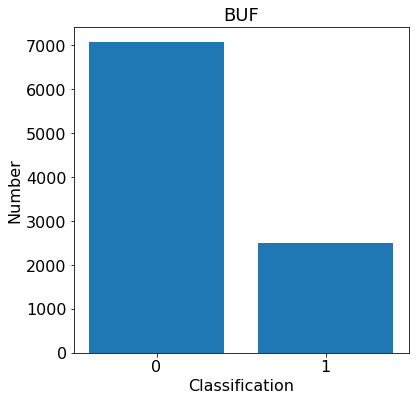

In [19]:
# Show Label Histogram
if plotLabelHist:
    histNums, histOut = np.unique(Yall, return_counts=True)
    plt.figure(figsize=[6,6])
    plt.bar(histNums,histOut)
    plt.title(dataSet)
    plt.ylabel('Number')
    plt.xlabel('Classification')
    plt.xticks([0,1],labels=['0','1'])

In [20]:
# Plot Feature Distributions
if plotDistData:
    f1 = 'T21'
    f2 = 'SZA'
    myFlatOpt = 10

    if (not exists('myFlatSave')): myFlatSave=None 
    if not exists('pos_df') or not exists('neg_df') or myFlatSave != myFlatOpt:
        print('Calculating Data Frame')
        
        myFlatSave = myFlatOpt
        XFlat,XLabelFlat = flatten_data(myFlatOpt, Xall, Tempall, verbose=True)
        print('  Flattened Data.')
    
        XFlat = normalize_data(XFlat)
        print('  Normalized Data.')
    
        boolAll = Yall != 0
        pos_df = pd.DataFrame(XFlat[ boolAll], columns=XLabelFlat)
        neg_df = pd.DataFrame(XFlat[~boolAll], columns=XLabelFlat)
    
    sns.jointplot(pos_df[f1], pos_df[f2], kind='hex', 
                  xlim =(-5,5), ylim=(-5,5))
    plt.suptitle("Icing", x=0.2, y=0.92)
    
    sns.jointplot(neg_df[f1], neg_df[f2], kind='hex',
                  xlim=(-5,5), ylim=(-5,5))
    _ = plt.suptitle("No Icing", x=0.2, y=0.92)

In [21]:
# Plot four scenes for one channel
if (plotSampleScene):
    plot_sample_images(Xall, Yall)

In [22]:
# Plot a scene for all channels
if plotSampleChannels:
    plot_scene_all_channels(Xall, Yall)

### Split Data into Training and Testing

For this study, I used 80% of the data for training and 20% for testing.  Since icing at both airports is imbalanced, care was taken to ensure both subsets maintain the original classification distribution.  Additionally, all evaluation will be done using the balanced accuracy scoring method.

In [23]:
trainFrac = 0.8
shuffleData = True

In [24]:
# Make a train/test split
XTrain, TempTrain, YTrain, XTest, TempTest, YTest = \
    partition_data(Xall, Tempall, Yall, trainFraction=trainFrac)
nVars = Xall.shape[1] + Tempall.shape[1]

Data Stats:
  Train Ice: 2008, No Ice: 5658 (26.194% ice) 
  Test Ice: 502, No Ice: 1414 (26.200% ice)
  Train: 7666, Test: 1916 (20% Test)


In [25]:
# Shuffle the data
if shuffleData:
    shuffle_data(XTrain, TempTrain, YTrain)
    shuffle_data(XTest, TempTest, YTest)
    print("Shuffled Data!")

Shuffled Data!


# 3 Neural Network Hyper-Parameter Search Space


### Input Data Features 
Input data features are options during the data pre-processing phase. <br>
This search space consists of two elements:
* <b>Flattening Technique.</b>
Images are flattened using one of 15 different possibilities, ranging from using the center pixel to the mean and standard deviation of the entire image. <br><br>
* <b>Number of Features.</b>
Input variables are selected according to the highest score using the Chi-Squared Statistic.  For both datasets, the number of features in the search space ranges from two up to the number of variables provided in the dataset. <br><br>


### Network Architecture Features 
Architecture features are options associated with the neural network setup. <br>
This search space consists of two elements:

* <b>Dropout Rate</b><br>
Use a uniform distribution in finding an appropriate dropout value. <br>
hp.uniform('dropout', 0.0, 0.4) <br>

* <b>Number of Dense Layers</b><br>
Determine the number of hidden dense layers, ranging from 1 to 8.
hp.choice('ndense', range(8)) <br>

### Network Parameters
Parameters are options associated with the nueral network implementation. <br>
This search space consists of six elements:

* <b>Activation</b><br>
Select from three different activation types: exponential, rectified linear unit, and hyperbolic tangent.<br>
hp.choice('activation', ['elu','relu','tanh']) <br><br>

* <b>Batch Size</b><br>
Vary the batch size fed for each gradient update from 100 to 700, incrementing by 5.<br>
hp.quniform('batch_size', 100, 700, 5)<br><br>

* <b>Beta 1</b><br>
Vary the exponential decay rate for the 1st moment estimates, ranging from 0.8 to 1.0.<br>
hp.uniform('beta_1', 0.8, 1.0)<br><br>

* <b>Beta 2</b><br>
Vary the exponential decay rate for the 2nd moment estimates, ranging from 0.9 to 1.0.<br>
hp.uniform('beta_2', 0.9, 1.0)<br><br>

* <b>Learning Rate</b><br>
Use a loguniform scale to make it vary exponentially in a multiplicative fashion. <br>
hp.loguniform('lr_rate', -0.5, 0.5) <br><br>

* <b>Initial Accumulator Value</b><br>
Vary the initial accumulator value for the Adagrad optimizer using a multiplier on the default value of 0.1.
hp.loguniform('iacc_mult', -0.2, 0.2)<br><br>

* <b>Number of Epochs</b><br>
Vary the number of epochs for training, ranging from 10 to 200.<br>
hp.choice('nepochs', [10,20,40,60,80,100,120,150,200])<br><br>

* <b>Number of Hidden Units</b><br>
Vary the number of hidden units from 8 to 200, specifying the range per dense layer.  The overarching approach is to initially increase the range and number of hidden units and then decrease towards the maximum number of layers. <br>
hp.choice('nhidden', range(8,200) <br><br>

* <b>Optimizer</b><br>
Select from four different optimizer options: Adagrad, Adam, NAdam, and SCG. <br>
hp.choice('optimizer', ['Adagrad','Adam','Nadam','SCG']) <br>



## Search Method: [Hyperopt](http://jaberg.github.io/hyperopt/)
The data pre-processing, network building components, and model parameters will be searched using [Hyperopt](http://proceedings.mlr.press/v28/bergstra13.pdf).


## Search Evaluation
I will use both a train/test split and cross-validation to evaluate my models.  The hyperparameter optimization will be conducted on the training split; however, to find the best options and avoid overfitting I will use 3-fold cross-validation in the parameter searches.  Once the optimal options and parameters have been found using the training dataset, the final model selection will be based on model performance for the testing split.  The top ten models from a guided search on the training data (using cross-validation) will then be evaluated on the hold-out testing data for final model recommendations.

## Search Definition

In [26]:
# SEARCH SPACE DEFINITION
if not exists('nVars'):
    nVars = 50
space = {
    'flatten': hp.choice('flatten',range(nFlatOpt)),
    'n_features': hp.choice('nfeatures', range(2,nVars)),
    'batch_size': hp.quniform('batch_size', 100, 600, 5),
    'nepochs': hp.choice('nepochs', [10,20,40,60,80,100,120,150,200]),
    'ndense': hp.choice('ndense', range(2,10)),
    'activation1': hp.choice('activation1', ['elu','relu','tanh']),
    'activation2': hp.choice('activation2', ['elu','relu','tanh']),
    'activation3': hp.choice('activation3', ['elu','relu','tanh']),
    'activation4': hp.choice('activation4', ['elu','relu','tanh']),
    'activation5': hp.choice('activation5', ['elu','relu','tanh']),
    'activation6': hp.choice('activation6', ['elu','relu','tanh']),
    'activation7': hp.choice('activation7', ['elu','relu','tanh']),
    'activation8': hp.choice('activation8', ['elu','relu','tanh']),
    'activation9': hp.choice('activation9', ['elu','relu','tanh']),
    'activation10': hp.choice('activation10', ['elu','relu','tanh']),
    'dropout2': hp.uniform('dropout2', 0.0, 0.3),
    'dropout3': hp.uniform('dropout3', 0.0, 0.3),
    'dropout4': hp.uniform('dropout4', 0.0, 0.3),
    'dropout5': hp.uniform('dropout5', 0.0, 0.3),
    'dropout6': hp.uniform('dropout6', 0.0, 0.3),
    'dropout7': hp.uniform('dropout7', 0.0, 0.3),
    'dropout8': hp.uniform('dropout8', 0.0, 0.3),
    'dropout9': hp.uniform('dropout9', 0.0, 0.3),
    'nunits1': hp.choice('nunits1', range(8,40)),
    'nunits2': hp.choice('nunits2', range(20,80)),
    'nunits3': hp.choice('nunits3', range(60,120)),
    'nunits4': hp.choice('nunits4', range(100,200)),
    'nunits5': hp.choice('nunits5', range(60,120)),
    'nunits6': hp.choice('nunits6', range(40,120)),
    'nunits7': hp.choice('nunits7', range(30,100)),
    'nunits8': hp.choice('nunits8', range(20,80)),
    'nunits9': hp.choice('nunits9', range(10,60)),
    'optimizer': hp.choice('optimizer', ['Adagrad','Adam','Nadam','SGD']),
    'beta_1': hp.uniform('beta_1', 0.8, 1.0),
    'beta_2': hp.uniform('beta_2', 0.9, 1.0),
    'iacc_mult': hp.loguniform('iacc_mult', -0.2, 0.2),
    'lr_mult': hp.loguniform('lr_mult', -0.5, 0.5),
    'momentum': hp.uniform('momentum', 0.0, 0.6)
}

# 4 Neural Network Model Setup

### Build Functions

In [43]:
# BUILD MODEL FUNCTION
def build_model(params, nFeatures=0, output_bias=None):

    METRICS = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
    
    # Setup bias
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    # Save information from params
    opt = params['optimizer']
    if opt == 'Adagrad':
        myOpt = tf.keras.optimizers.Adagrad(
                    learning_rate=params['lr_mult']*0.001,
                    initial_accumulator_value=params['iacc_mult']*0.1)
    elif opt == 'Adam':
        myOpt = tf.keras.optimizers.Adam(
                    learning_rate=params['lr_mult']*0.001, 
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'Nadam':
        myOpt = tf.keras.optimizers.Nadam(
                    learning_rate=params['lr_mult']*0.001,
                    beta_1=params['beta_1'], beta_2=params['beta_2'])
    elif opt == 'SGD':
        myOpt = tf.keras.optimizers.SGD(
                    learning_rate=params['lr_mult']*0.01,
                    momentum=params['momentum'])
    else:
        print("UNKNOWN OPTIMIZER. STOPPING.")
        sys_exit()
    
    # Define model
    model = Sequential()
    if nFeatures == 0:
        model.add(Dense(params['nunits1'], activation=params['activation1']))
    else:
        model.add(Dense(params['nunits1'], activation=params['activation1'], 
                        input_shape=(nFeatures,)))
    
    myActivation = ['activation2','activation2','activation3','activation4',
                    'activation5','activation6','activation7','activation8',
                    'activation9']
    myDropOut = ['dropout2','dropout3','dropout4','dropout5','dropout6',
                 'dropout7','dropout8','dropout9']
    myHiddenUnits = ['nunits2','nunits3','nunits4','nunits5','nunits6',
                     'nunits7','nunits8','nunits9']
    nLayers = params['ndense']-1
    for i in range(nLayers):
        model.add(Dense(params[myHiddenUnits[i]], 
                        activation=params[myActivation[i]]))
        model.add(Dropout(params[myDropOut[i]]))
        
    model.add(Dense(1, activation='sigmoid', 
                    bias_initializer=output_bias))

    # Compile Model
    model.compile(optimizer=myOpt, loss='binary_crossentropy', 
                  metrics=METRICS)

    return model

In [28]:
# TRAIN MODEL FUNCTION
def train_model(params, X, Temp, Y, nCVSplits=3,
                output_bias=None, verbose=False):
      
    # Set the data
    y_ = Y[:]
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    X_ = select_data(X, Temp, y_, params)
    nFeatures = X_.shape[1]

    # Build the model
    model = build_model(params, nFeatures=nFeatures, output_bias=output_bias)
    if verbose:
        model.summary()

    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X_, y_)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X_[train_index],X_[test_index]
        y_train,y_test=y_[train_index],y_[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
        
    # Add balanced accuracy
    add_balAcc(history)
        
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Clean up environment
    del model
    tf.keras.backend.clear_session()
    
    return history

In [29]:
# TEST MODEL FUNCTION
def test_model(params, XTrain, TempTrain, YTrain,
                  XTest, TempTest, YTest, nCVSplits=3,
                  output_bias=None, verbose=False,
                  YPrint=False, YConf=False, 
                  YConfTitle=None,YConfSave=None):

    # Set the data
    y_ = YTrain[:]
    yTest_ = YTest[:]
    nEpochs = params['nepochs']
    sBatch = int(params['batch_size'])
    
    # Make pre-processing selections
    X_ = select_data(XTrain, TempTrain, y_, params)
    XTest_ = select_data(XTest, TempTest, yTest_, params)
    nFeatures = X_.shape[1]

    # Build the model
    model = build_model(params, nFeatures=nFeatures, output_bias=output_bias)
    if verbose:
        model.summary()
        
    # Train using cross-validation
    dCV = StratifiedKFold(n_splits=nCVSplits, shuffle=True)
    dCV_iter = dCV.split(X_, y_)
    history = {}
    for train_index, test_index in dCV_iter:
        x_train,x_test=X_[train_index],X_[test_index]
        y_train,y_test=y_[train_index],y_[test_index]
        histNow = model.fit(x_train, y_train, epochs=nEpochs, 
                            batch_size=sBatch, verbose=0,
                            validation_data=(x_test,y_test))
        for key, val in histNow.history.items():
            if key in history:
                tempL = history[key]
                count=0
                for vh in val:
                    tempL[count].append(vh)
                    count+=1
            else:
                tempL = []
                for vh in val:
                    tempL.append([vh])
                history[key] = tempL
    
    # Add balanced accuracy to history
    add_balAcc(history)
    
    # Create mean and standard deviation of cv results
    myItems = list(history.items())
    for key, val in myItems:
        newMean = []
        newStd = []
        for i in range(nEpochs):
            newMean.append(np.mean(val[i]))
            newStd.append(np.std(val[i],ddof=1))
            
        history[key] = newMean
        newKey = key + '_std'
        history[newKey] = newStd
    history['epoch'] = np.arange(1,nEpochs+1)
    
    # Evaluate
    resultsList = model.evaluate(XTest_, yTest_, verbose=0)
    results = dict_Results(resultsList)
    add_balAcc(results)
    
    # Make Precitions
    y_predict = (model.predict(XTest_) > 0.5).astype("int32")[:,0]
    if YPrint:
        nIce = len(np.where(yTest_ == 1)[0])
        nNon = len(np.where(yTest_ == 0)[0])
        nIceP = len(np.where(y_predict == 1)[0])
        nNonP = len(np.where(y_predict == 0)[0])
        nMis = len(np.where(y_predict != yTest_)[0])
        
        print("Number of Cases: {}".format(yTest_.shape[0]))
        print("  True Ice: {}, Predicted Ice: {}".format(nIce, nIceP))
        print("  True Non: {}, Predicted Non: {}".format(nNon, nNonP))
        print("  Number of Mismatches: {}".format(nMis))
    
    # Plot confusion matrix
    if YConf:
        cmatrix = confusion_matrix(yTest_, y_predict)
        disp = plot_confusion_matrix(cmatrix, ['No Ice','Ice'],
                                     cTitle=YConfTitle) 
        
        if YConfSave:
            plt.savefig(YConfSave,bbox_inches='tight')

    # Clean up environment
    del model
    tf.keras.backend.clear_session()
            
    return results, history, y_predict

### TPE Functions

In [30]:
# BALANCED ACCURACY FUNCTION
def add_balAcc(history):
    tp = np.array(history['tp'])
    fp = np.array(history['fp'])
    tn = np.array(history['tn'])
    fn = np.array(history['fn'])
    balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
    history['balAcc'] = balAcc
    
    keyList = list(history.keys())
    if 'val_tp' in keyList:
        tp = np.array(history['val_tp'])
        fp = np.array(history['val_fp'])
        tn = np.array(history['val_tn'])
        fn = np.array(history['val_fn'])
        balAcc = ((tp/(tp+fn) + tn/(fp+tn))*0.5).tolist()
        history['val_balAcc'] = balAcc

In [31]:
# CONVERT RESULTS TO DICTIONARY
def dict_Results(results):
    
    resultsDict = {}
    metrics = ['loss','tp','fp','tn','fn','accuracy','precision',
               'recall','auc']
    nMetrics = len(metrics)
    
    count=0
    for m in metrics:
        resultsDict[m] = results[count]
        count+=1
        
    return resultsDict

In [32]:
# DATA SELECTION FUNCTION
def select_data(X, Temp, Y, params):
    if 'flatten' in params:
        nFlatOpt = params['flatten']
    else:
        nFlatOpt = 0
    X_, XLabels = flatten_data(nFlatOpt, X, Temp)
    X_ = normalize_data(X_)
    
    if 'n_features' in params:
        nFeatures = params['n_features']
        if nFeatures < nVars:
            mySelect = SelectKBest(f_classif, k=nFeatures)
            X_ = mySelect.fit_transform(X_, Y)

    return X_

In [33]:
# TPE OPTIMIZE FUNCTION
def hyperopt_f(params, X, Temp, Y, nPrintInfo=1, trainVerbose=False,
               saveFreq=10, saveFile='hpResults_'):
    
    global bestA, countA, paramA, spaceA, trialsA, timeA
    countA += 1  
    if countA % nPrintInfo == 0:
        print('Count: {}, Params: {}'.format(countA, params))
        
    history = train_model(params.copy(), X, Temp, Y, verbose=trainVerbose)
    balAcc = history['val_balAcc'][-1]
    if balAcc > bestA:
        bestA = balAcc
        spaceA = params
        
    if countA % nPrintInfo == 0:
        print('  Best: {:.2f}, Acc: {:.2f}'.format(bestA*100., balAcc*100.))

    if countA % saveFreq == 0:
        fileNow = saveFile + str(countA) + 'p.pkl'
        with open(fileNow, 'wb') as handle:
            timeT = time.time() - timeA
            pickle.dump([bestA, spaceA, trialsA, timeT], handle,
                        protocol=pickle.HIGHEST_PROTOCOL)
            
    return {'loss': -balAcc, 'status': STATUS_OK} 

In [34]:
# TPE RUN TRIALS FUNCTION
def run_trials(hyperopt_f, X, Temp, Y, 
               nMaxEvals=10, nPrintEvals=1,
               saveFreq=10, saveFile='hpResults',
               verbose=True, trainVerbose=False):

    global bestA, spaceA, trialsA, timeA
    
    fpartial = partial(hyperopt_f, X=XTrain, 
                       Temp=TempTrain, Y=YTrain,
                       nPrintInfo=nPrintEvals, 
                       trainVerbose=trainVerbose,
                       saveFreq=saveFreq, saveFile=saveFile)
    best = fmin(fpartial, spaceA, algo=tpe.suggest,
                max_evals=nMaxEvals, trials=trialsA)
    
    bestSpace = space_eval(spaceA, best)
    timeT = time.time() - timeA
    
    if saveFreq != 0:
        fileNow = saveFile + str(nMaxEvals) + '.pkl'
        with open(fileNow, 'wb') as handle:
            pickle.dump([bestA, bestSpace, trialsA, timeT], handle,
                       protocol=pickle.HIGHEST_PROTOCOL)
            
    if verbose:
        print('')
        print('--------------------------------------')
        print('Finished Search in {:.3f}s'.format(timeT))
        print('Best Parameters: {}'.format(bestSpace))
        print('Best CV Train Accuracy: {:.3f}'.format(bestA*100.))
        print('')

    return trialsA

### Plot Functions

In [35]:
# PLOT MODEL FROM HYPERSPACE
def plot(hyperspace, file_name_prefix=''):
    model = build_model(hyperspace)
    if file_name_prefix != '':
        model.summary()
        plot_model(
            model,
            to_file='{}.png'.format(file_name_prefix),
            show_shapes=True)

        print("Saved model visualization to {}.png".format(file_name_prefix))
    else:
        plot_model(model, show_shapes=True)
        
    del model

In [36]:
# PLOT LOSS
def plot_loss(history, label='', n=0):
    plt.semilogy(history['epoch'], history['loss'], 
                 color=myColors[n], label='Train '+label)
    plt.semilogy(history['epoch'], history['val_loss'],
                color=myColors[n], label='Val '+label, linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [37]:
# PLOT ACCURACY
def plot_accuracy(history, label='', n=0, balanced=False):
    ep1 = history['epoch']
    acc1 = np.array(history['accuracy'])*100.
    acc2 = np.array(history['val_accuracy'])*100.
    plt.plot(ep1, acc1, color=myColors[n], label='Train '+label)
    plt.plot(ep1, acc2, color=myColors[n], label='Val '+label, linestyle='--')
    
    if balanced:
        acc3 = np.array(history['balAcc'])*100.
        acc4 = np.array(history['val_balAcc'])*100.
        plt.plot(ep1, acc3, color=myColors[n+4], label='BAcc Train '+label)
        plt.plot(ep1, acc4, color=myColors[n+4], label='BAcc Val '+label, linestyle='--')
        plt.legend(ncol=2)
    else:
        plt.legend()
        
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')


### Testing Functions

In [69]:
plotBase = False
trainBase = False
testBase = True

In [68]:
# DEFINE BASE MODEL
if plotBase or trainBase or testBase:
    space_base = {
    'flatten': 2,
    'n_features': 50,
    'batch_size': 300,
    'nepochs': 5,
    'ndense': 2,
    'activation1': 'relu',
    'activation2': 'relu',
    'dropout2': 0.2,
    'nunits1': 10,
    'nunits2': 40,
    'optimizer': 'Adam',
    'beta_1': 0.9,
    'beta_2': 0.99,
    'iacc_mult': 1.0,
    'lr_mult': 1.0,
    'momentum': 0.0
    }
    
    buf_base = {'activation1': 'elu', 'activation10': 'elu', 
                'activation2': 'relu', 'activation3': 'relu', 'activation4': 'elu', 
                'activation5': 'tanh', 'activation6': 'tanh', 'activation7': 'elu', 
                'activation8': 'tanh', 'activation9': 'relu', 'batch_size': 515.0, 
                'beta_1': 0.8924404629721687, 'beta_2': 0.9006325018593956, 
                'dropout2': 0.2816577182220378, 'dropout3': 0.17953828584081716, 
                'dropout4': 0.2130509361643551, 'dropout5': 0.00652786196452498, 
                'dropout6': 0.2631014184249306, 'dropout7': 0.28216824529600354, 
                'dropout8': 0.12637254945454898, 'dropout9': 0.044081069920880636, 
                'flatten': 7, 'iacc_mult': 0.9273884126660487, 
                'lr_mult': 1.4235058684994033, 'momentum': 0.3871530959523905, 
                'n_features': 45, 'ndense': 6, 'nepochs': 150, 'nunits1': 19, 
                'nunits2': 60, 'nunits3': 91, 'nunits4': 170, 'nunits5': 69, 
                'nunits6': 43, 'nunits7': 56, 'nunits8': 58, 'nunits9': 14, 
                'optimizer': 'Nadam'}
    
    dtw_base = {'activation1': 'relu', 'activation10': 'tanh', 'activation2': 'relu', 
     'activation3': 'tanh', 'activation4': 'tanh', 'activation5': 'relu', 
     'activation6': 'elu', 'activation7': 'elu', 'activation8': 'tanh', 
     'activation9': 'relu', 'batch_size': 470.0, 'beta_1': 0.9379001507366728, 
     'beta_2': 0.9784134744986102, 'dropout2': 0.0798303541647005, 
     'dropout3': 0.06920031889248072, 'dropout4': 0.026341893344610026, 
     'dropout5': 0.15170751768637547, 'dropout6': 0.0483144385226707, 
     'dropout7': 0.26371518310906517, 'dropout8': 0.1348123140266686, 
     'dropout9': 0.1992485451186278, 'flatten': 1, 'iacc_mult': 0.8585646654198055, 
     'lr_mult': 1.0649336866088195, 'momentum': 0.47523329073252485, 'n_features': 32, 
     'ndense': 9, 'nepochs': 150, 'nunits1': 28, 'nunits2': 79, 'nunits3': 98, 
     'nunits4': 147, 'nunits5': 77, 'nunits6': 93, 'nunits7': 92, 'nunits8': 26, 
     'nunits9': 56, 'optimizer': 'Adam'}
    
    both_base = {'activation1': 'tanh', 'activation10': 'tanh', 'activation2': 'relu', 
                 'activation3': 'relu', 'activation4': 'tanh', 'activation5': 'relu', 
                 'activation6': 'relu', 'activation7': 'relu', 'activation8': 'elu', 
                 'activation9': 'tanh', 'batch_size': 310.0, 
                 'beta_1': 0.8627466015158621, 'beta_2': 0.9747507645209749, 
                 'dropout2': 0.08157354400018531, 'dropout3': 0.06601151132256688, 
                 'dropout4': 0.11612522432162467, 'dropout5': 0.047138722300476985, 
                 'dropout6': 0.10658328369852353, 'dropout7': 0.15673704154826062, 
                 'dropout8': 0.17807642083071587, 'dropout9': 0.13081352693995604, 
                 'flatten': 0, 'iacc_mult': 1.1213678398112985, 
                 'lr_mult': 1.1119124967834038, 'momentum': 0.3064307827983943, 
                 'n_features': 52, 'ndense': 5, 'nepochs': 120, 'nunits1': 21, 
                 'nunits2': 73, 'nunits3': 119, 'nunits4': 137, 'nunits5': 114, 
                 'nunits6': 88, 'nunits7': 36, 'nunits8': 22, 'nunits9': 51, 
                 'optimizer': 'Adam'}

In [46]:
# PLOT BASE MODEL
if plotBase:
        
    plot(buf_base, "buf_base")

In [47]:
# TRAIN BASE MODEL AND PLOT LOSS/ACCURACY
if trainBase and \
   (not exists('myHistB') or not exists('myHistO')):
        
    initial_bias = np.log([pos/neg])
    myHistB = train_model(buf_base, XTrain, TempTrain, YTrain, 
                          output_bias=initial_bias, verbose=True)

    #myHistO = train_model(buf_base, XTrain, TempTrain, YTrain, 
    #                      output_bias=None)

if trainBase:
    f = plt.figure(figsize=(20,12))
    ax = f.add_subplot(121)
    #plot_loss(myHistO, label='No Bias', n=0)
    plot_loss(myHistB, label='Bias', n=1)
    
    ax2 = f.add_subplot(122)
    #plot_accuracy(myHistO, label='No Bias', n=0, balanced=True)
    plot_accuracy(myHistB, label='Bias', n=1, balanced=True)

In [48]:
# BUILD AND TEST BASE MODEL
if testBase:
    myTitle = dataSet + 'Best NN Confusion Matrix'
    myConfSave = dirIn + 'BOTH_Confusion.png'
    myResults, myHistory, myPredict = test_model(
        both_base, XTrain, TempTrain, YTrain, XTest, TempTest, YTest,
        YPrint=True, YConf=True, YConfTitle=myTitle, YConfSave=myConfSave)

# 4 TPE Hyperparameter Search

To perform a hyperparameter search in order to find the best neural network, Hyperopt implements the Tree-structured Parzen Estimator (TPE).  TPE is a sequential model-based optimization approach that sequentially constructs models to approximate the performance of hyperparameters based on historical measurements ([Claesen et al, 2014](https://optunity.readthedocs.io/en/latest/user/solvers/TPE.html#tpe2011)).

### Perform Search

In [49]:
doSearch = False
nMaxEvals = 1
nPrintEvals = 1

saveSearch = True
saveFreq = 1
saveFile = dirIn + 'save/' + dataSet + '_Results'
trainVerbose = True

In [50]:
# HYPERPARAMETER SEARCH USING HYPEROPT TPE
if doSearch:
    bestA=0
    countA=0
    paramsA={}
    spaceA=space
    timeA=time.time()
    trialsA=Trials()
    
    nnTrials = run_trials(hyperopt_f, XTrain, TempTrain, YTrain, 
                          nMaxEvals=nMaxEvals, nPrintEvals=nPrintEvals,
                          saveFreq=saveFreq, saveFile=saveFile,
                          trainVerbose=trainVerbose)

# 5 Analysis

### Calculate Test Accuracies
To investigate search results and find the best model, calculate the performance of the select top trials on the test dataset. This will save the output into another pickle file containing the training and testing output that can be used to create plots and tables.

In [51]:
calcTestAcc = False
calcTopN = 20

printNCheck = 1
inTrialFile = dirIn + 'save/' + dataSet + '_Results200.pkl'
saveTestFile = dirIn + 'save/' + dataSet + '_TestResults' + str(calcTopN) + '.pkl'

In [52]:
# Open Trial Results and Save Test Results
if calcTestAcc:
    with open(inTrialFile, 'rb') as handle:
        allTemp = pickle.load(handle)
        bestA = allTemp[0]
        bestSpace = allTemp[1]
        allTrials = allTemp[2]
    
    nTrials = len(allTrials.trials)
    nTop = min(nTrials, calcTopN)
    
    topAcc = []
    topParams = []
    minAcc = -999
    for mt in allTrials.trials:
        accHere = -mt['result']['loss']  
        if len(topAcc) < nTop:
                topAcc.append(accHere)
                pHere = mt['misc']['vals']
                for key, val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams.append(pNow)
                
        elif accHere > minAcc:
                topAcc[nTop-1] = accHere
                pHere = mt['misc']['vals']
                for key,val in pHere.items():
                    pHere[key] = val[0]
                pNow = space_eval(space, pHere)
                topParams[nTop-1] = pNow

        if (len(topAcc) > 2):
            topAcc, topParams = zip(*sorted(zip(
                   topAcc, topParams), 
                   reverse=True, key=lambda x: x[0]))
            topAcc = list(topAcc)
            topParams = list(topParams)

        minAcc = min(topAcc)

    topCV = []
    topTest = []
    for i in range(nTop):
        history = train_model(topParams[i], XTrain, TempTrain, YTrain)
        topCV.append(history['val_balAcc'][-1])
        tResults, tHistory, tPredict = test_model(topParams[i], XTrain, 
                    TempTrain, YTrain, XTest, TempTest, YTest)
        topTest.append(tResults['balAcc'])
        if ((i % printNCheck) == 0):
            print('Number {}: Acc Orig= {:.3f}, CV= {:.3f}, Test= {:.3f}'.format(
               i, topAcc[i], topCV[i], topTest[i]))
  
    topTest, topAcc, topCV, topParams = zip(*sorted(zip(
        topTest, topAcc, topCV, topParams), reverse=True, key=lambda x: x[0]))
    with open(saveTestFile, 'wb') as handle:
          pickle.dump([topAcc, topCV, topTest, topParams],
                       handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('Created File: ',saveTestFile)

### Plot Confusion Matrix

In [53]:
plotConfusion = False
saveConfusion = False
inTestFileC = dirIn + 'save/' + dataSet + '_TestResults20.pkl'

In [54]:
# Show confusion matrix
if plotConfusion:
    with open(inTestFileC, 'rb') as handle:
        allTemp = pickle.load(handle)
    topAcc = allTemp[0]
    topCV = allTemp[1]
    topTest = allTemp[2]
    topParams = allTemp[3]
    
    print('Best Orig Train Accuracy: {:.1f}% and Test Train Accuracy: {:.1f}%'. \
         format(topAcc[0]*100., topCV[0]*100.))    
    print('Best Params: ', topParams[0])
    print()
      
    myFile = dataSet + '_NNConfusion.png'
    myTitle = dataSet + ' NN Confusion Matrix'
    tResults, tHistory, tPredict = test_model(topParams[0], 
                                XTrain, TempTrain, YTrain,
                                XTest, TempTest, YTest, verbose=True,
                                YConf=True, YConfTitle=myTitle, 
                                YConfSave=myFile)
    print('Best Testing Accuracy Saved: {:.2f}% and Re-Calculated{:.2f}%' \
           .format(topTest[0]*100., tResults['balAcc']*100.))

### Compare Buffalo and Detroit

In [61]:
compareBoth = True
showTopBoth = True
plotTopBoth = True
saveTopBoth = True

fileBUF = dirIn + 'nn_save/BUF_TestResults20.pkl'
fileDTW = dirIn + 'nn_save/DTW_TestResults20.pkl'
fileBOTH = dirIn + 'nn_save/BOTH_TestResults20.pkl'

In [70]:
# Create a dataframe
if compareBoth:
    
    with open(fileBUF,'rb') as handle:
        allTemp = pickle.load(handle)
    topAccBUF = allTemp[0]
    topCVBUF = allTemp[1]
    topTestBUF = allTemp[2]
    topParamsBUF = allTemp[3]
        
    with open(fileDTW,'rb') as handle:
        allTemp = pickle.load(handle)
    topAccDTW = allTemp[0]
    topCVDTW = allTemp[1]
    topTestDTW = allTemp[2]
    topParamsDTW = allTemp[3]
    
    with open(fileBOTH,'rb') as handle:
        allTemp = pickle.load(handle)
    topAccB = allTemp[0]
    topCVB = allTemp[1]
    topTestB = allTemp[2]
    topParamsB = allTemp[3]
    
    # Create data frame
    results = []
    topN = len(topAccBUF)
    for i in range(topN):
        BUFNow = topParamsBUF[i]
        DTWNow = topParamsDTW[i]
        BOTHNow = topParamsB[i]

        results.append([topCVBUF[i],topTestBUF[i],topCVDTW[i],topTestDTW[i],
                        topCVB[i], topTestB[i],
                        BUFNow['flatten'], BUFNow['n_features'], BUFNow['nepochs'],
                        BUFNow['ndense'], BUFNow['optimizer'],
                        DTWNow['flatten'], DTWNow['n_features'], DTWNow['nepochs'],
                        DTWNow['ndense'], DTWNow['optimizer'],
                        BOTHNow['flatten'], BOTHNow['n_features'], BOTHNow['nepochs'],
                        BOTHNow['ndense'], BOTHNow['optimizer'],
                        ])
    
    dfResults = pd.DataFrame(results, columns=[
                'BUF_Train','BUF_Test', 
                'DTW_Train','DTW_Test',
                'BOTH_Train','BOTH_Test',
                'BUF_Flat','BUF_Feats','BUF_Epochs',
                'BUF_Dense','BUF_Optimizer',
                'DTW_Flat','DTW_Feats', 'DTW_Epochs',
                'DTW_Dense','DTW_Optimizer',
                'BOTH_Flat','BOTH_Feats', 'BOTH_Epochs',
                'BOTH_Dense','BOTH_Optimizer',])

In [71]:
# Show Results
if compareBoth and showTopBoth:
     
    dfSubResultsB = dfResults.loc[:,['BUF_Test','BUF_Train',
                        'BUF_Flat','BUF_Feats', 'BUF_Epochs',
                        'BUF_Dense','BUF_Optimizer']]

    display(dfSubResultsB)
    print("Top BUF Test Accuracy: {:.3f}".format(topTestBUF[0]*100.))
    print("Top BUF Model: {}".format(topParamsBUF[0]))

    dfSubResultsR = dfResults.loc[:,['DTW_Test','DTW_Train',
                                     'DTW_Flat','DTW_Feats', 'DTW_Epochs',
                                     'DTW_Dense','DTW_Optimizer']]
    display(dfSubResultsR)
    print("Top DTW Test Accuracy: {:.3f}".format(topTestDTW[0]*100.))
    print("Top DTW Model: {}".format(topParamsDTW[0]))
    
    dfSubResultsC = dfResults.loc[:,['BOTH_Test','BOTH_Train',
                                     'BOTH_Flat','BOTH_Feats', 'BOTH_Epochs',
                                     'BOTH_Dense','BOTH_Optimizer']]
    display(dfSubResultsC)
    print("Top BOTH Test Accuracy: {:.3f}".format(topTestB[0]*100.))
    print("Top BOTH Model: {}".format(topParamsB[0]))

BUF_Test  BUF_Train  BUF_Flat  BUF_Feats  BUF_Epochs  BUF_Dense  \
0   0.937169   0.934785         7         45         150          6   
1   0.933115   0.927872         7         45         150          6   
2   0.931641   0.918653         7         25         150          6   
3   0.924451   0.931760         7         45         150          6   
4   0.919241   0.929693         7         45         150          6   
5   0.919041   0.920031         8         40         120          6   
6   0.864773   0.922944         5         31         150          5   
7   0.741443   0.931957        12         47         150          6   
8   0.722750   0.901174         9         50         120          7   
9   0.686197   0.926175         5         41         150          6   
10  0.618798   0.928208         7         35         150          6   
11  0.590916   0.934224         3         55         200          6   
12  0.589772   0.942857         3         29         150          6   
13  0.586377   0.922591         7         40         120          6   
14  0.585524   0.925683         7         55          40          6   
15  0.576696   0.937230         7         44         150          6   
16  0.561760   0.927591        12         34         150          6   
17  0.541192   0.922833         7         20         150          6   
18  0.540296   0.926098         7         35         150          6   
19  0.520022   0.926793        12         34         150          6   

   BUF_Optimizer  
0          Nadam  
1          Nadam  
2          Nadam  
3          Nadam  
4          Nadam  
5          Nadam  
6          Nadam  
7          Nadam  
8          Nadam  
9          Nadam  
10         Nadam  
11         Nadam  
12         Nadam  
13         Nadam  
14         Nadam  
15         Nadam  
16         Nadam  
17         Nadam  
18         Nadam  
19         Nadam

Top BUF Test Accuracy: 93.717
Top BUF Model: {'activation1': 'elu', 'activation10': 'elu', 'activation2': 'relu', 'activation3': 'relu', 'activation4': 'elu', 'activation5': 'tanh', 'activation6': 'tanh', 'activation7': 'elu', 'activation8': 'tanh', 'activation9': 'relu', 'batch_size': 515.0, 'beta_1': 0.8924404629721687, 'beta_2': 0.9006325018593956, 'dropout2': 0.2816577182220378, 'dropout3': 0.17953828584081716, 'dropout4': 0.2130509361643551, 'dropout5': 0.00652786196452498, 'dropout6': 0.2631014184249306, 'dropout7': 0.28216824529600354, 'dropout8': 0.12637254945454898, 'dropout9': 0.044081069920880636, 'flatten': 7, 'iacc_mult': 0.9273884126660487, 'lr_mult': 1.4235058684994033, 'momentum': 0.3871530959523905, 'n_features': 45, 'ndense': 6, 'nepochs': 150, 'nunits1': 19, 'nunits2': 60, 'nunits3': 91, 'nunits4': 170, 'nunits5': 69, 'nunits6': 43, 'nunits7': 56, 'nunits8': 58, 'nunits9': 14, 'optimizer': 'Nadam'}


DTW_Test  DTW_Train  DTW_Flat  DTW_Feats  DTW_Epochs  DTW_Dense  \
0   0.595754   0.899711         1         32         150          9   
1   0.595192   0.886055         8         49         150          4   
2   0.585256   0.893105         9         46         150          4   
3   0.578986   0.883329         7         47         100          7   
4   0.570936   0.868574        10         29         150          4   
5   0.566882   0.897372        10         40         150          9   
6   0.560852   0.878972         9         46         150          4   
7   0.560333   0.872736        10         38         150          4   
8   0.556898   0.882066        10         43         150          7   
9   0.553860   0.884015        10         43         150          4   
10  0.551867   0.892500        10         43         150          4   
11  0.544303   0.870628        10         27         150          4   
12  0.540182   0.878578        10         41         150          4   
13  0.529699   0.880379         3         30         200          4   
14  0.529204   0.898507        10         27         150          4   
15  0.527830   0.863765        13         27         150          4   
16  0.527706   0.887026        10         43         150          4   
17  0.527199   0.878968        13         46         150          4   
18  0.517866   0.860230        12         26         150          4   
19  0.499487   0.861048        12         36         100          4   

   DTW_Optimizer  
0           Adam  
1           Adam  
2           Adam  
3           Adam  
4           Adam  
5           Adam  
6          Nadam  
7           Adam  
8           Adam  
9           Adam  
10          Adam  
11          Adam  
12          Adam  
13         Nadam  
14          Adam  
15          Adam  
16          Adam  
17         Nadam  
18          Adam  
19         Nadam

Top DTW Test Accuracy: 59.575
Top DTW Model: {'activation1': 'relu', 'activation10': 'tanh', 'activation2': 'relu', 'activation3': 'tanh', 'activation4': 'tanh', 'activation5': 'relu', 'activation6': 'elu', 'activation7': 'elu', 'activation8': 'tanh', 'activation9': 'relu', 'batch_size': 470.0, 'beta_1': 0.9379001507366728, 'beta_2': 0.9784134744986102, 'dropout2': 0.0798303541647005, 'dropout3': 0.06920031889248072, 'dropout4': 0.026341893344610026, 'dropout5': 0.15170751768637547, 'dropout6': 0.0483144385226707, 'dropout7': 0.26371518310906517, 'dropout8': 0.1348123140266686, 'dropout9': 0.1992485451186278, 'flatten': 1, 'iacc_mult': 0.8585646654198055, 'lr_mult': 1.0649336866088195, 'momentum': 0.47523329073252485, 'n_features': 32, 'ndense': 9, 'nepochs': 150, 'nunits1': 28, 'nunits2': 79, 'nunits3': 98, 'nunits4': 147, 'nunits5': 77, 'nunits6': 93, 'nunits7': 92, 'nunits8': 26, 'nunits9': 56, 'optimizer': 'Adam'}


BOTH_Test  BOTH_Train  BOTH_Flat  BOTH_Feats  BOTH_Epochs  BOTH_Dense  \
0    0.888021    0.902852          0          52          120           5   
1    0.882593    0.901961          8          26          150           9   
2    0.759867    0.856677          1          30          150           4   
3    0.751835    0.907963          1          30          150           4   
4    0.651885    0.893903          2          44          150           8   
5    0.649522    0.886909          5          30          150           9   
6    0.648639    0.882771          9          32          200           9   
7    0.628127    0.874632          5          37          100           5   
8    0.604959    0.900881          8          32          200           9   
9    0.590674    0.896183          8          25          200           9   
10   0.589917    0.894924          5          39          150           5   
11   0.580420    0.899587         14          33          120           5   
12   0.572091    0.868377          6          51          200           7   
13   0.567286    0.888734          3          47          150           4   
14   0.563163    0.901335         14          52          120           5   
15   0.544373    0.881195         13          39          150           9   
16   0.543111    0.893697          8          32          150           9   
17   0.534509    0.886461         10          25          200           9   
18   0.530196    0.906346         14          52          120           5   
19   0.516878    0.901080         13          39          150           5   

   BOTH_Optimizer  
0            Adam  
1            Adam  
2            Adam  
3            Adam  
4            Adam  
5           Nadam  
6            Adam  
7            Adam  
8            Adam  
9            Adam  
10           Adam  
11           Adam  
12           Adam  
13           Adam  
14           Adam  
15           Adam  
16           Adam  
17           Adam  
18           Adam  
19           Adam

Top BOTH Test Accuracy: 88.802
Top BOTH Model: {'activation1': 'tanh', 'activation10': 'tanh', 'activation2': 'relu', 'activation3': 'relu', 'activation4': 'tanh', 'activation5': 'relu', 'activation6': 'relu', 'activation7': 'relu', 'activation8': 'elu', 'activation9': 'tanh', 'batch_size': 310.0, 'beta_1': 0.8627466015158621, 'beta_2': 0.9747507645209749, 'dropout2': 0.08157354400018531, 'dropout3': 0.06601151132256688, 'dropout4': 0.11612522432162467, 'dropout5': 0.047138722300476985, 'dropout6': 0.10658328369852353, 'dropout7': 0.15673704154826062, 'dropout8': 0.17807642083071587, 'dropout9': 0.13081352693995604, 'flatten': 0, 'iacc_mult': 1.1213678398112985, 'lr_mult': 1.1119124967834038, 'momentum': 0.3064307827983943, 'n_features': 52, 'ndense': 5, 'nepochs': 120, 'nunits1': 21, 'nunits2': 73, 'nunits3': 119, 'nunits4': 137, 'nunits5': 114, 'nunits6': 88, 'nunits7': 36, 'nunits8': 22, 'nunits9': 51, 'optimizer': 'Adam'}


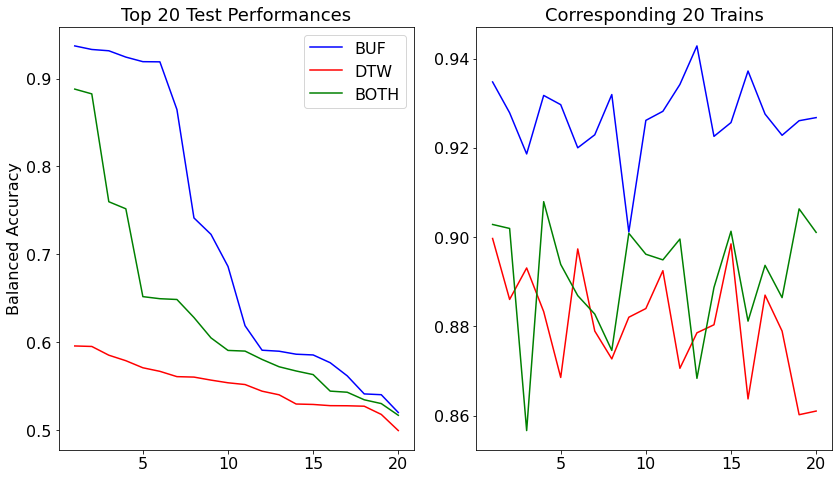

In [74]:
# Plot Top Guided Accuracies
if compareBoth and plotTopBoth:

    # Create plots
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12,7))
    xs = np.arange(1,topN+1,dtype=int)
        
    axes[0].plot(xs,dfResults['BUF_Test'],color='b',label='BUF')
    axes[0].plot(xs,dfResults['DTW_Test'],color='r',label='DTW')
    axes[0].plot(xs,dfResults['BOTH_Test'],color='g',label='BOTH')
    axes[0].set_title('Top {} Test Performances'.format(topN))
    axes[0].set_ylabel('Balanced Accuracy')
    axes[0].legend()

    axes[1].plot(xs,dfResults['BUF_Train'],color='b',label='BUF')
    axes[1].plot(xs,dfResults['DTW_Train'],color='r',label='DTW')
    axes[1].plot(xs,dfResults['BOTH_Train'],color='g',label='BOTH')
    axes[1].set_title('Corresponding {} Trains'.format(topN))
    fig.tight_layout()
        
    if saveTopBoth:
        myFilename = 'NN_top' + str(topN) + '_accuracy.png'
        plt.savefig(myFilename,bbox_inches='tight')